# DLS Final Project 2024 | StyleGAN-NADA Reimplementation

In [1]:
!git clone -q https://github.com/NVlabs/stylegan2-ada-pytorch.git
!wget -q "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
!git clone -q https://github.com/omertov/encoder4editing.git
!pip install git+https://github.com/openai/CLIP.git -q
!pip install gdown -q
!gdown 1O8OLrVNOItOJoNGMyQ8G8YRTeTYEfs0P -q
!pip install dlib -q
!wget -q http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dkq shape_predictor_68_face_landmarks.dat.bz2
!rm -f shape_predictor_68_face_landmarks.dat.bz2

In [2]:
import os
os.environ["TORCH_CUDA_ARCH_LIST"] = "7.5"
from app import *
from torchvision.utils import make_grid
%matplotlib inline
from base64 import b64encode
from IPython.display import HTML

In [3]:
ffhq_dataset = "/mnt/hd0/data/ffhq-dataset/images1024x1024/02000"
batch_size = 1
dataset = FFHQDs(ffhq_dataset, 2)
dataloader = DataLoader(
    dataset, 
    batch_size=batch_size, 
)
len(dataset), len(dataloader)

(2, 2)

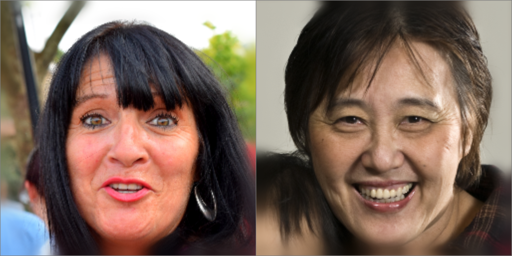

In [4]:
images = torch.cat([img for img in dataloader])
grid_img = tensor2im(make_grid(images, nrow=2)).resize((512, 256))
grid_img

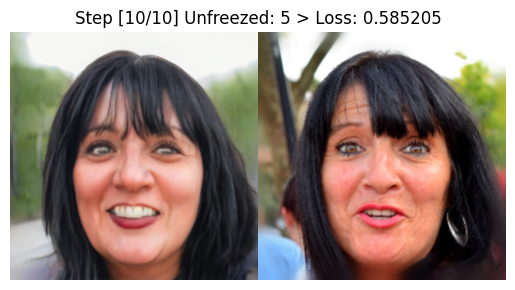

Saving images: 0it [00:00, ?it/s]

In [5]:
model = MyStyleGANa(ckpt_path="/tmp/G_ckpt.pt")

!rm -rf /tmp/frames
model.train(
    dataloader, "Photo", "Sketch", 
    num_steps=10, 
    lr=0.003, 
    fmin_steps=5, 
    fmin_evals=10, 
    patience=5,
    z_samples=3,
    display=True,
    outdir="/tmp/frames",
    save_freq=1,
)

In [6]:
def dispay_output(model, dataloader, n_samples, nrow):
    output = []
    for inputs in dataset:
        with torch.no_grad():
            w = model.encode_images(inputs.unsqueeze(0))
        generated_img = model.G.synthesis(w, noise_mode="const", force_fp32=True)
        output.append(generated_img.detach().cpu())
        if len(output) == n_samples:
            break
    return tensor2im(make_grid(torch.cat(output), nrow=nrow))

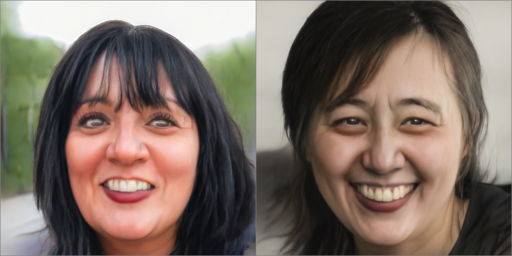

In [7]:
grid_img = dispay_output(model, dataloader, n_samples=2, nrow=2)
grid_img.resize((512, 256))

In [8]:
!ffmpeg -y -f image2 -r 25 -pattern_type glob -i "/tmp/frames/00000/000_*.png" \
    -vcodec libx264 -crf 25 -loglevel error /tmp/output.mp4

In [9]:
input_video = open("/tmp/output.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(input_video).decode()
HTML("""
<video width=512 controls><source src="%s" type="video/mp4">
</video>
""" % data_url)